In [1]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

print("TensorFlow version: ",tf.__version__)

2025-02-05 18:29:18.026706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-05 18:29:18.026735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-05 18:29:18.028177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 18:29:18.036389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version:  2.15.0


In [2]:
EPS = 2./255
IMAGENET_LABELS = "imagenet_class_index.json"

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

In [3]:
# Function to load up an image from a local filepath and
# display it
def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

# Function to preprocess an image for performing inference
def preprocess_image(image_pixels, preprocess=False):
    if preprocess:
        image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

# Clipping utility to project delta back to our favorable pixel
# range ([0 ,1])
def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, 
                            clip_value_min=-EPS, 
                            clip_value_max=EPS)

# Parse the label
def get_label(preds):
    print(IMAGENET_CLASSES[preds.argmax()])

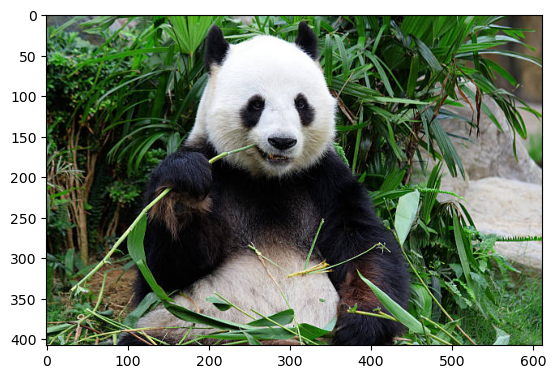

2025-02-05 18:29:21.139300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:8a:00.0, compute capability: 6.1


In [4]:
sample_image = show_image("./data/imagenet/giant_panda/giantpanda.jpg")
preprocessed_image = preprocess_image(sample_image, preprocess=True)
resnet50 = tf.keras.applications.ResNet50(weights="imagenet")

In [5]:
preds = resnet50.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

2025-02-05 18:29:24.378581: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 2s 2s/step
Predicted: [('n02510455', 'giant_panda', 0.99872273), ('n02509815', 'lesser_panda', 0.0005726167), ('n02488702', 'colobus', 0.0002929433)]
Class idx: 388


In [6]:
def generate_adversaries_targeted(image_tensor, delta, model,
    true_index, target_indices, optimizer):
    # Loss function
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = model(inp, training=False)
            true_loss = scc_loss(tf.convert_to_tensor([true_index]), predictions)
            target_losses = 0
            for i in target_indices:
                
                target_losses += scc_loss(tf.convert_to_tensor([i]), predictions)

            
            loss = true_loss + target_losses
            if t % 20 == 0:
                print(t, loss.numpy())
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Project the delta back (l-infinite norm)
        delta.assign_add(clip_eps(delta))

    return delta

# def perturb_image(image_path, true, target, model, optimizer):
#     # Load and preprocess image but a but without any `preprocess_input`
#     sample_image = show_image(image_path)
#     preprocessed_image = preprocess_image(sample_image)

#     # Generate predictions before any adversaries
#     unsafe_preds = model.predict(preprocess_input(preprocessed_image))
#     print("Prediction before adv.:", decode_predictions(unsafe_preds, top=3)[0])

#     # Initialize the perturbation quantity
#     image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
#     delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

#     # Get the learned delta and display it
#     delta_tensor = generate_adversaries_targeted(image_tensor, delta, model, 
#                                                  true, target, optimizer)
#     plt.imshow(50*delta_tensor.numpy().squeeze()+0.5)
#     plt.show()

#     # See if the image changes
#     plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
#     plt.show()

#     # Generate prediction
#     perturbed_image = preprocess_input(image_tensor + delta_tensor)
#     preds = model.predict(perturbed_image)
#     print("Prediction after adv.:", decode_predictions(preds, top=10)[0])

In [7]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to get logits and probability distribution
# def get_logits_and_probs(model, image):
#     logits = model(image, training=False)
#     probs = tf.nn.softmax(logits).numpy()
#     return logits.numpy(), probs  # Convert logits to NumPy array

# # Function to compare probability distributions
# def compare_distributions(original_probs, perturbed_probs, threshold=0.01):
#     diff = np.abs(original_probs - perturbed_probs)
#     significant_diff = diff > threshold
#     return significant_diff, diff



# # Modify the perturb_image function to include logits and probability comparison
# def perturb_image(image_path, true, target, model, optimizer):
#     # Load and preprocess image but without any `preprocess_input`
#     sample_image = show_image(image_path)
#     preprocessed_image = preprocess_image(sample_image)

#     # Generate predictions before any adversaries
#     original_image = preprocess_input(preprocessed_image)
#     original_logits, original_probs = get_logits_and_probs(model, original_image)
#     print("Original prediction:", decode_predictions(original_logits, top=3)[0])

#     # Initialize the perturbation quantity
#     image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
#     delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

#     # Get the learned delta and display it
#     delta_tensor = generate_adversaries_targeted(image_tensor, delta, model, 
#                                                  true, target, optimizer)
#     plt.imshow(50*delta_tensor.numpy().squeeze()+0.5)
#     plt.show()

#     # See if the image changes
#     plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
#     plt.show()

#     # Generate prediction after perturbation
#     perturbed_image = preprocess_input(image_tensor + delta_tensor)
#     perturbed_logits, perturbed_probs = get_logits_and_probs(model, perturbed_image)
#     print("Perturbed prediction:", decode_predictions(perturbed_logits, top=10)[0])

#     # Compare the probability distributions
#     significant_diff, diff = compare_distributions(original_probs, perturbed_probs)
#     print("Significant differences in probabilities:", significant_diff)
#     print("Difference in probabilities:", diff)

#     return original_probs, perturbed_probs

# # Example usage
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
# original_probs, perturbed_probs = perturb_image("pufferfish.jpg", 397, [389,508,234,768,456], resnet50, optimizer)

# # You can further analyze original_probs and perturbed_probs to check for watermarks

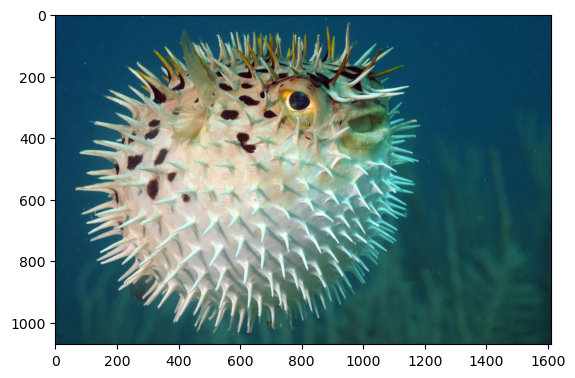

Original prediction: [('n02655020', 'puffer', 0.99995553), ('n02319095', 'sea_urchin', 3.9033876e-05), ('n01914609', 'sea_anemone', 1.328663e-06)]
0 122.10994
20 88.53377
40 68.687065
60 56.372112
80 48.78186
100 44.14082
120 41.289413
140 39.35655
160 37.907616
180 36.894062
200 36.102028
220 35.45008
240 34.87896
260 34.363922
280 33.8897
300 33.46652
320 33.072056
340 32.735386


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


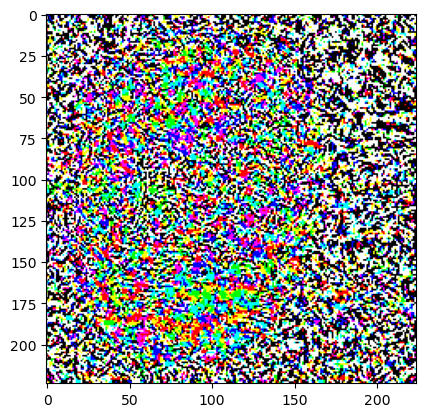

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


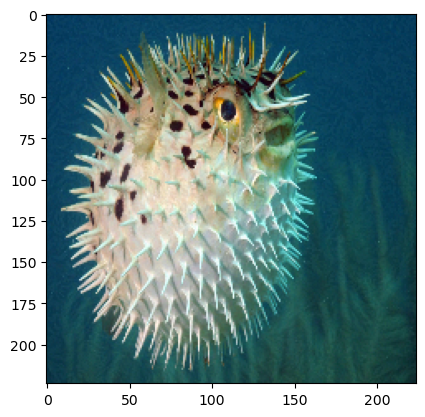

Perturbed prediction: [('n02655020', 'puffer', 0.092805095), ('n02319095', 'sea_urchin', 0.042337123), ('n02106550', 'Rottweiler', 0.039992113), ('n04039381', 'racket', 0.033777494), ('n10565667', 'scuba_diver', 0.026566887), ('n02643566', 'lionfish', 0.025304144), ('n01914609', 'sea_anemone', 0.021890488), ('n09256479', 'coral_reef', 0.021086708), ('n04370456', 'sweatshirt', 0.01911822), ('n03595614', 'jersey', 0.01297117)]
Significant differences in probabilities for target indices: [ True  True  True  True  True]
Difference in probabilities for target indices: [1.0613585e-06 2.1704473e-06 4.1468651e-05 2.6108464e-06 2.6572961e-06]


In [10]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to get logits and probability distribution
# def get_logits_and_probs(model, image):
#     logits = model(image, training=False)
#     probs = tf.nn.softmax(logits).numpy()
#     return logits.numpy(), probs  # Convert logits to NumPy array

# # Function to compare probability distributions for target indices only
# def compare_distributions(original_probs, perturbed_probs, target_indices, threshold=0.000001):
#     # Extract probabilities for the target indices
#     original_target_probs = original_probs[0, target_indices]  # Shape: (num_targets,)
#     perturbed_target_probs = perturbed_probs[0, target_indices]  # Shape: (num_targets,)
    
#     # Calculate the absolute difference
#     diff = np.abs(original_target_probs - perturbed_target_probs)
    
#     # Check if the difference exceeds the threshold
#     significant_diff = diff > threshold
    
#     return significant_diff, diff

# # Modify the perturb_image function to include logits and probability comparison for target indices
# def perturb_image(image_path, true, target_indices, model, optimizer):
#     # Load and preprocess image but without any `preprocess_input`
#     sample_image = show_image(image_path)
#     preprocessed_image = preprocess_image(sample_image)

#     # Generate predictions before any adversaries
#     original_image = preprocess_input(preprocessed_image)
#     original_logits, original_probs = get_logits_and_probs(model, original_image)
#     print("Original prediction:", decode_predictions(original_logits, top=3)[0])

#     # Initialize the perturbation quantity
#     image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
#     delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

#     # Get the learned delta and display it
#     delta_tensor = generate_adversaries_targeted(image_tensor, delta, model, 
#                                                  true, target_indices, optimizer)
#     plt.imshow(50*delta_tensor.numpy().squeeze()+0.5)
#     plt.show()

#     # See if the image changes
#     plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
#     plt.show()

#     # Generate prediction after perturbation
#     perturbed_image = preprocess_input(image_tensor + delta_tensor)
#     perturbed_logits, perturbed_probs = get_logits_and_probs(model, perturbed_image)
#     print("Perturbed prediction:", decode_predictions(perturbed_logits, top=10)[0])

#     # Compare the probability distributions for target indices only
#     significant_diff, diff = compare_distributions(original_probs, perturbed_probs, target_indices)
#     print("Significant differences in probabilities for target indices:", significant_diff)
#     print("Difference in probabilities for target indices:", diff)

#     return original_probs, perturbed_probs

# # Example usage
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
# target_indices = [389, 508, 234, 768, 456]  # Example target indices
# original_probs, perturbed_probs = perturb_image("pufferfish.jpg", 397, target_indices, resnet50, optimizer)

# # You can further analyze original_probs and perturbed_probs for the target indices

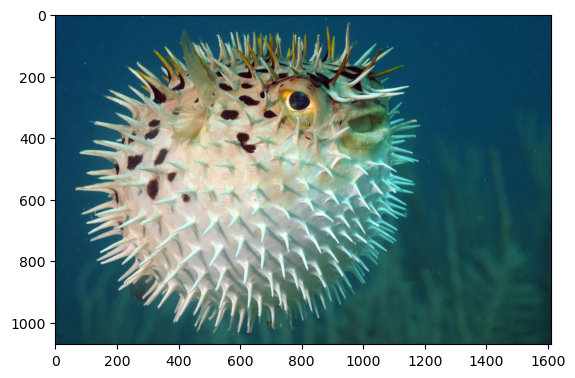

Original prediction: [('n02655020', 'puffer', 0.99995553), ('n02319095', 'sea_urchin', 3.9033876e-05), ('n01914609', 'sea_anemone', 1.328663e-06)]
0 122.10994
20 88.53435
40 68.68564
60 56.37277
80 48.785175
100 44.135582
120 41.301495
140 39.358032
160 37.891407
180 36.882816
200 36.095436
220 35.442905
240 34.861065
260 34.358215
280 33.91355
300 33.502655
320 33.11386
340 32.76456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


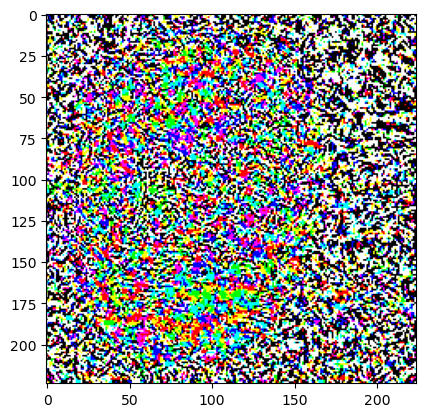

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


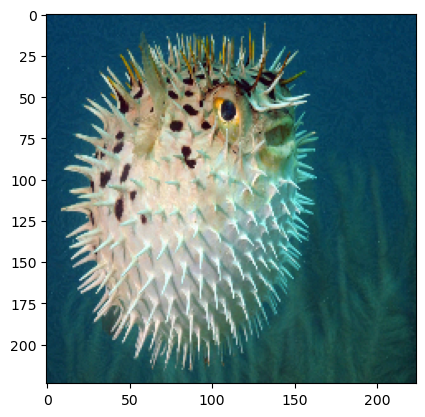

Perturbed prediction: [('n02655020', 'puffer', 0.093098804), ('n02319095', 'sea_urchin', 0.04279852), ('n02106550', 'Rottweiler', 0.039138366), ('n04039381', 'racket', 0.033883825), ('n10565667', 'scuba_diver', 0.026645504), ('n02643566', 'lionfish', 0.025460439), ('n01914609', 'sea_anemone', 0.021857334), ('n09256479', 'coral_reef', 0.021384867), ('n04370456', 'sweatshirt', 0.018817857), ('n03595614', 'jersey', 0.012616739)]
Significant differences in probabilities: [[ True  True  True  True  True  True  True False False False False  True
  False False False False False False False False False  True False  True
  False False False False False False False False False  True False False
  False False False  True False False False False False False  True False
   True False False  True False False False  True False False False False
   True False False False False  True False False False  True False False
  False False False False  True False False  True  True False  True  True
   True Fa

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to get logits and probability distribution
def get_logits_and_probs(model, image):
    logits = model(image, training=False)
    probs = tf.nn.softmax(logits).numpy()
    return logits.numpy(), probs  # Convert logits to NumPy array

# Function to compare probability distributions
def compare_distributions(original_probs, perturbed_probs, threshold=0.000001):
    diff = np.abs(original_probs - perturbed_probs)
    significant_diff = diff > threshold
    return significant_diff, diff

# Modify the perturb_image function to include logits and probability comparison
def perturb_image(image_path, true, target, model, optimizer):
    # Load and preprocess image but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)

    # Generate predictions before any adversaries
    original_image = preprocess_input(preprocessed_image)
    original_logits, original_probs = get_logits_and_probs(model, original_image)
    print("Original prediction:", decode_predictions(original_logits, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the learned delta and display it
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, model, 
                                                 true, target, optimizer)
    plt.imshow(50*delta_tensor.numpy().squeeze()+0.5)
    plt.show()

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction after perturbation
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    perturbed_logits, perturbed_probs = get_logits_and_probs(model, perturbed_image)
    print("Perturbed prediction:", decode_predictions(perturbed_logits, top=10)[0])

    # Compare the probability distributions
    significant_diff, diff = compare_distributions(original_probs, perturbed_probs)
    print("Significant differences in probabilities:", significant_diff)
    print("Difference in probabilities:", diff)

    return original_probs, perturbed_probs

# Example usage
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
original_probs, perturbed_probs = perturb_image("pufferfish.jpg", 397, [389,508,234,768,456], resnet50, optimizer)

# You can further analyze original_probs and perturbed_probs to check for watermarks

In [9]:
# #@title Adam
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
# # perturb_image("./data/imagenet/giant_panda/giantpanda.jpg", 388, [389,508], resnet50, optimizer)
# perturb_image("pufferfish.jpg", 397, [389,508,234,768,456], resnet50, optimizer)